# 🎨 Sampling Visualization

You can use this notebook to visualize your trained models.

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

plt.style.use('default')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Load a Trained Model

First, let's load a trained checkpoint. Update the path to your trained model.

In [ ]:
import yaml
from src.models import create_model_from_config
from src.methods import DDPM, FlowMatching
from src.utils import EMA

def load_model(checkpoint_path, method='ddpm'):
    """Load a trained model from checkpoint."""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    config = checkpoint['config']

    # Create model
    model = create_model_from_config(config).to(device)
    model.load_state_dict(checkpoint['model'])

    # Load EMA weights
    ema = EMA(model, decay=config['training']['ema_decay'])
    ema.load_state_dict(checkpoint['ema'])
    ema.apply_shadow()  # Use EMA weights

    # Create method
    if method == 'ddpm':
        diffusion = DDPM.from_config(model, config, device)
    else:
        diffusion = FlowMatching.from_config(model, config, device)

    diffusion.eval_mode()
    return diffusion, config

In [ ]:
# ============================================
# UPDATE THIS PATH TO YOUR TRAINED MODEL
# ============================================
CHECKPOINT_PATH = 'YOUR_PATH'
METHOD = 'ddpm'  # 'ddpm' or 'flow_matching' or any of your custom method names

import os

if os.path.exists(CHECKPOINT_PATH):
    # Load trained model
    print(f"Loading trained model from {CHECKPOINT_PATH}...")
    diffusion, config = load_model(CHECKPOINT_PATH, METHOD)
    print(f"✓ Loaded {METHOD} model")
else:
    # Create untrained model for demonstration
    print("⚠️ No checkpoint found. Creating untrained model for demonstration.")
    print("   Samples will be random noise - train a model first for real results!")
    print()
    
    with open('YOUR_MODEL_CONFIG.yaml', 'r') as f:
        config = yaml.safe_load(f)
    
    from src.models import create_model_from_config
    from src.methods import DDPM, FlowMatching
    
    model = create_model_from_config(config).to(device)
    diffusion = DDPM.from_config(model, config, device) # Change DDPM to your method class name
    diffusion.eval_mode()

In [ ]:
# Display model information
def count_parameters(model):
    """Count total and trainable parameters in a model."""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Get the underlying model
if hasattr(diffusion, 'model'):
    model = diffusion.model
else:
    # If diffusion doesn't have a model attribute, use it directly
    model = diffusion

total_params, trainable_params = count_parameters(model)

print("=" * 60)
print("MODEL INFORMATION")
print("=" * 60)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / (1024**2):.2f} MB (FP32)")
print(f"Method: {METHOD}")
if os.path.exists(CHECKPOINT_PATH):
    print(f"Checkpoint: {CHECKPOINT_PATH}")
else:
    print("Checkpoint: None (untrained model)")
print("=" * 60)

MODEL INFORMATION
Total parameters: 18,532,803
Trainable parameters: 18,532,803
Model size: 70.70 MB (FP32)
Method: ddpm


This is the model size that I used to get a decently working model (KID around 0.0035, FID around 8). I trained it for around 5 hours on 4 L40S GPUs. I don't think you need 4 GPUs for this model, I have later trained the same model on a single L40S GPU and it was also able to work decently well after roughly the same amount of time (KID around 0.0039), I think you can probably train this model on a single L40S GPU for even shorter and still get a ok model (but this is not an excuse for you to procrastinate on starting the homework! Start early so that you have enough time to debug!!)

## 2. DDPM Sampling

The standard DDPM sampling algorithm iteratively denoises from pure noise. I have included a grid sampled from the model that I showed above for your reference here.

Sampling with DDPM (1000 steps)...
This may take a minute...
Trajectory shape: torch.Size([1001, 16, 3, 64, 64])


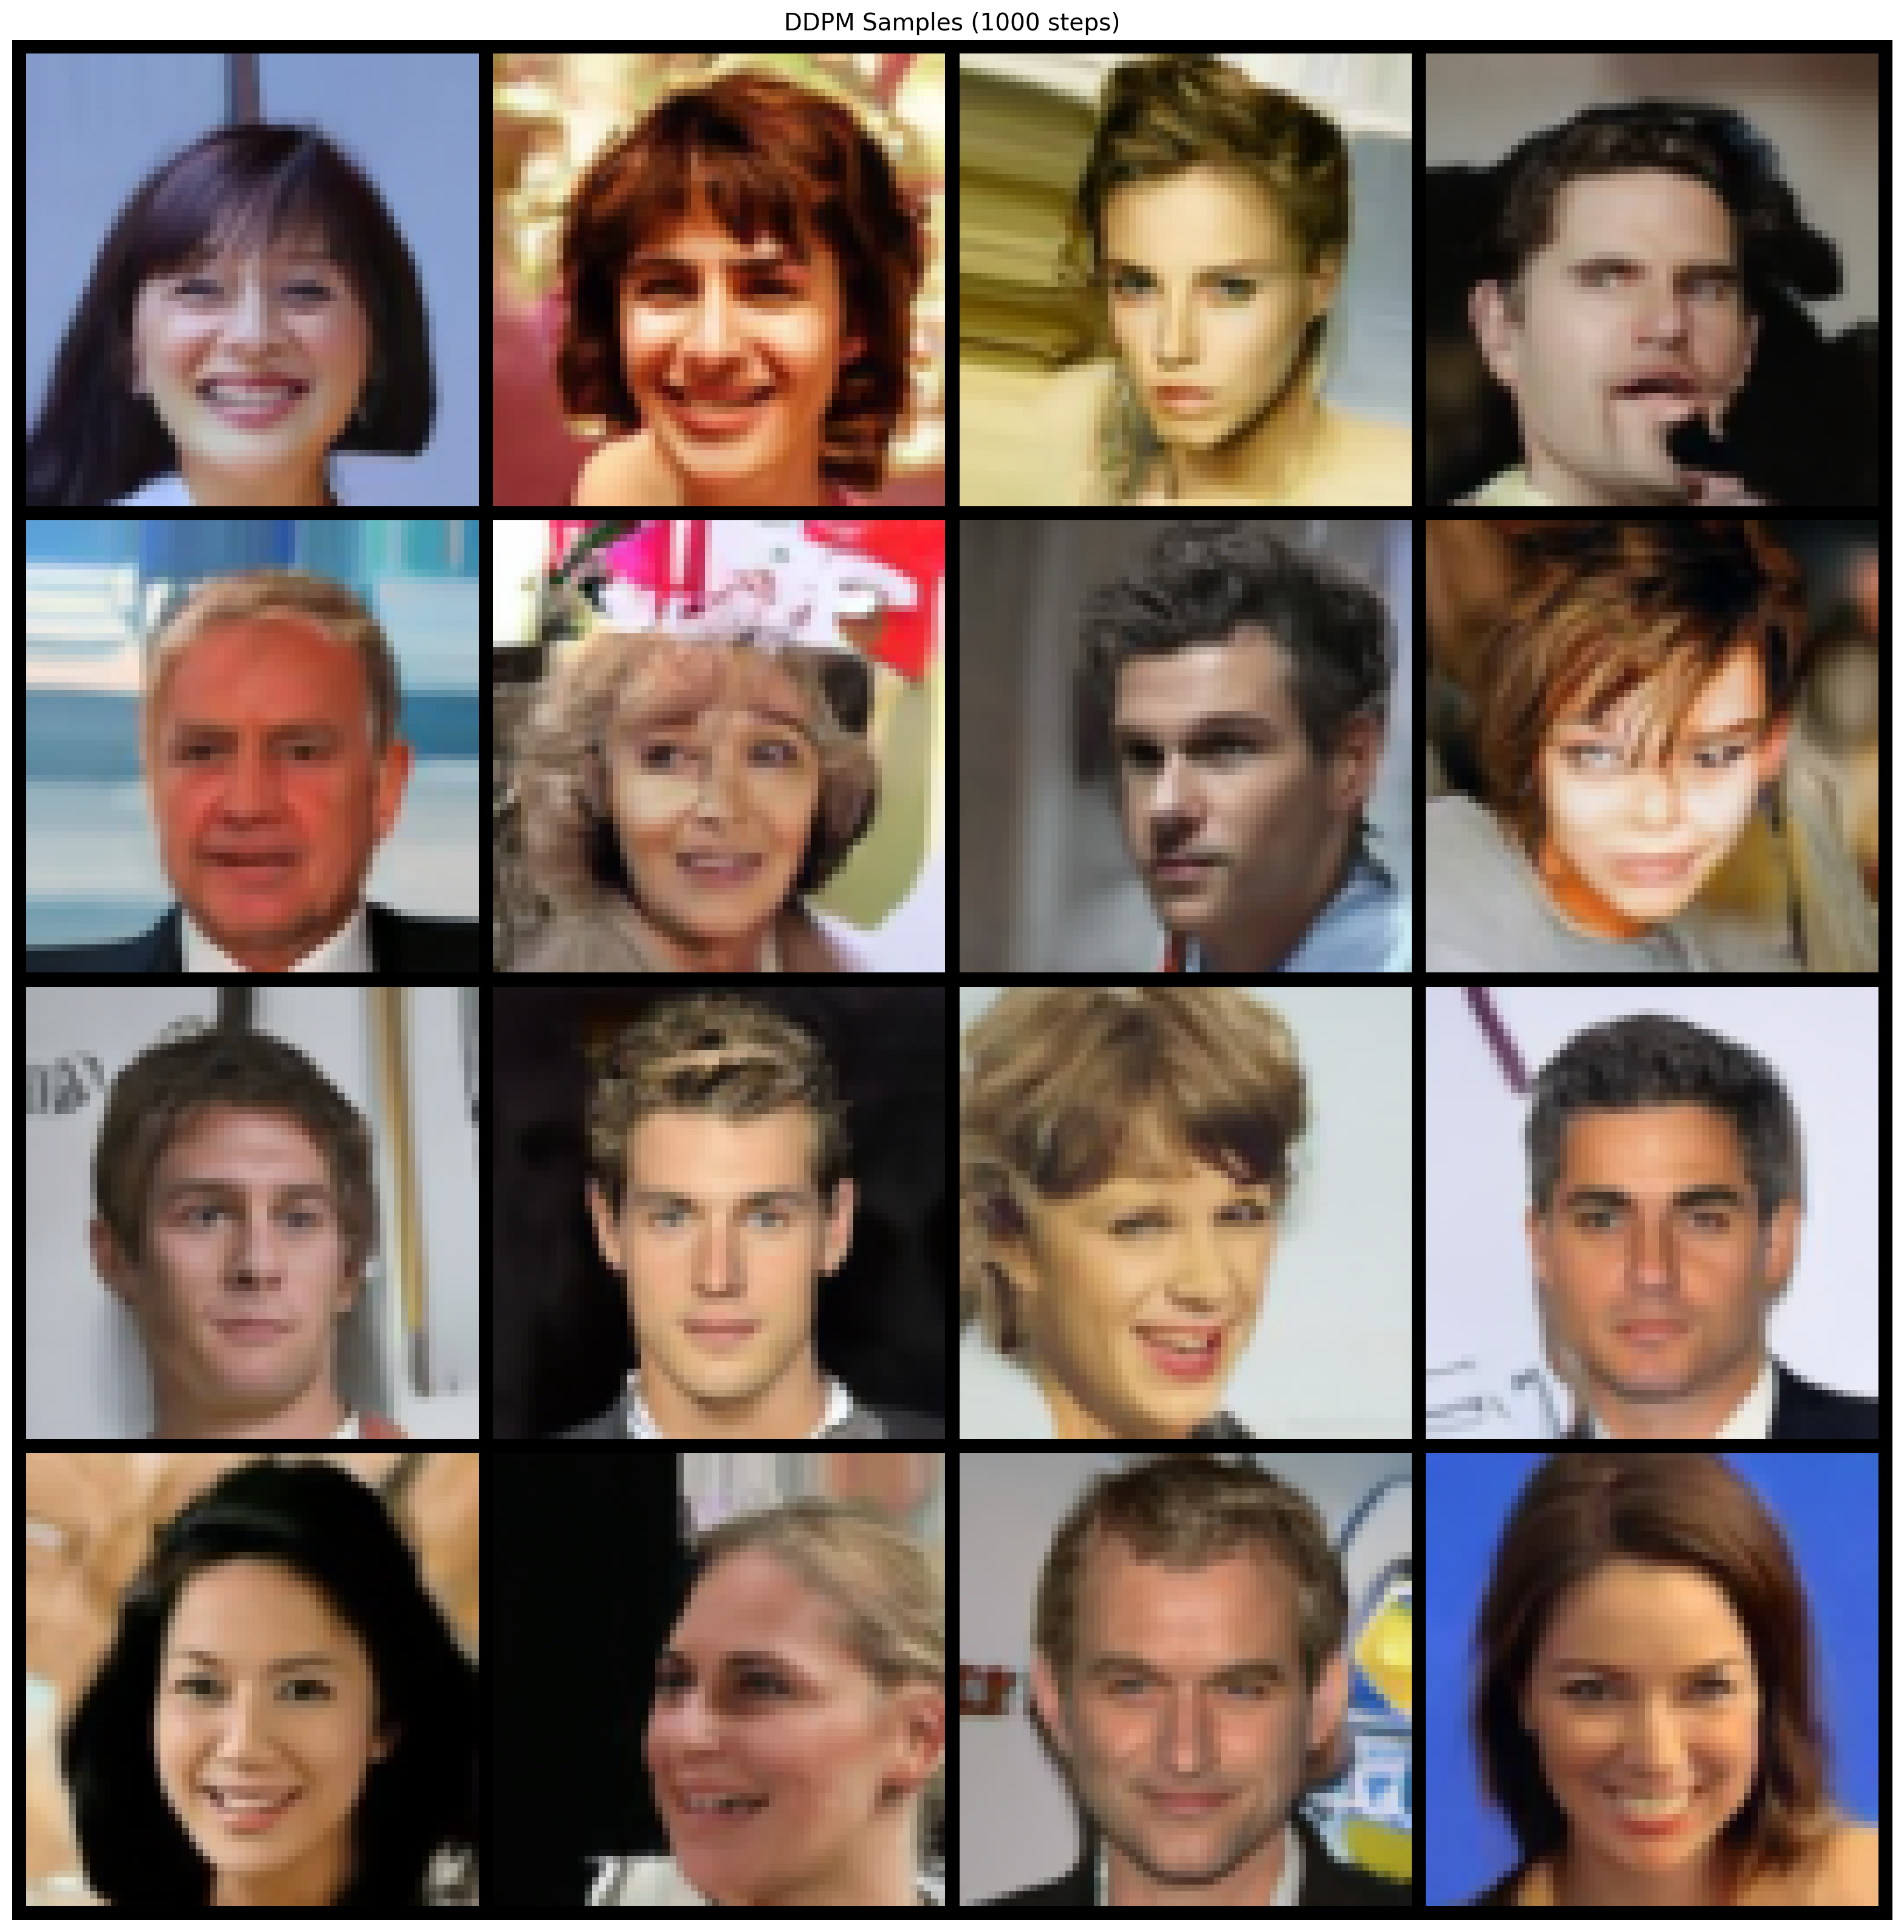

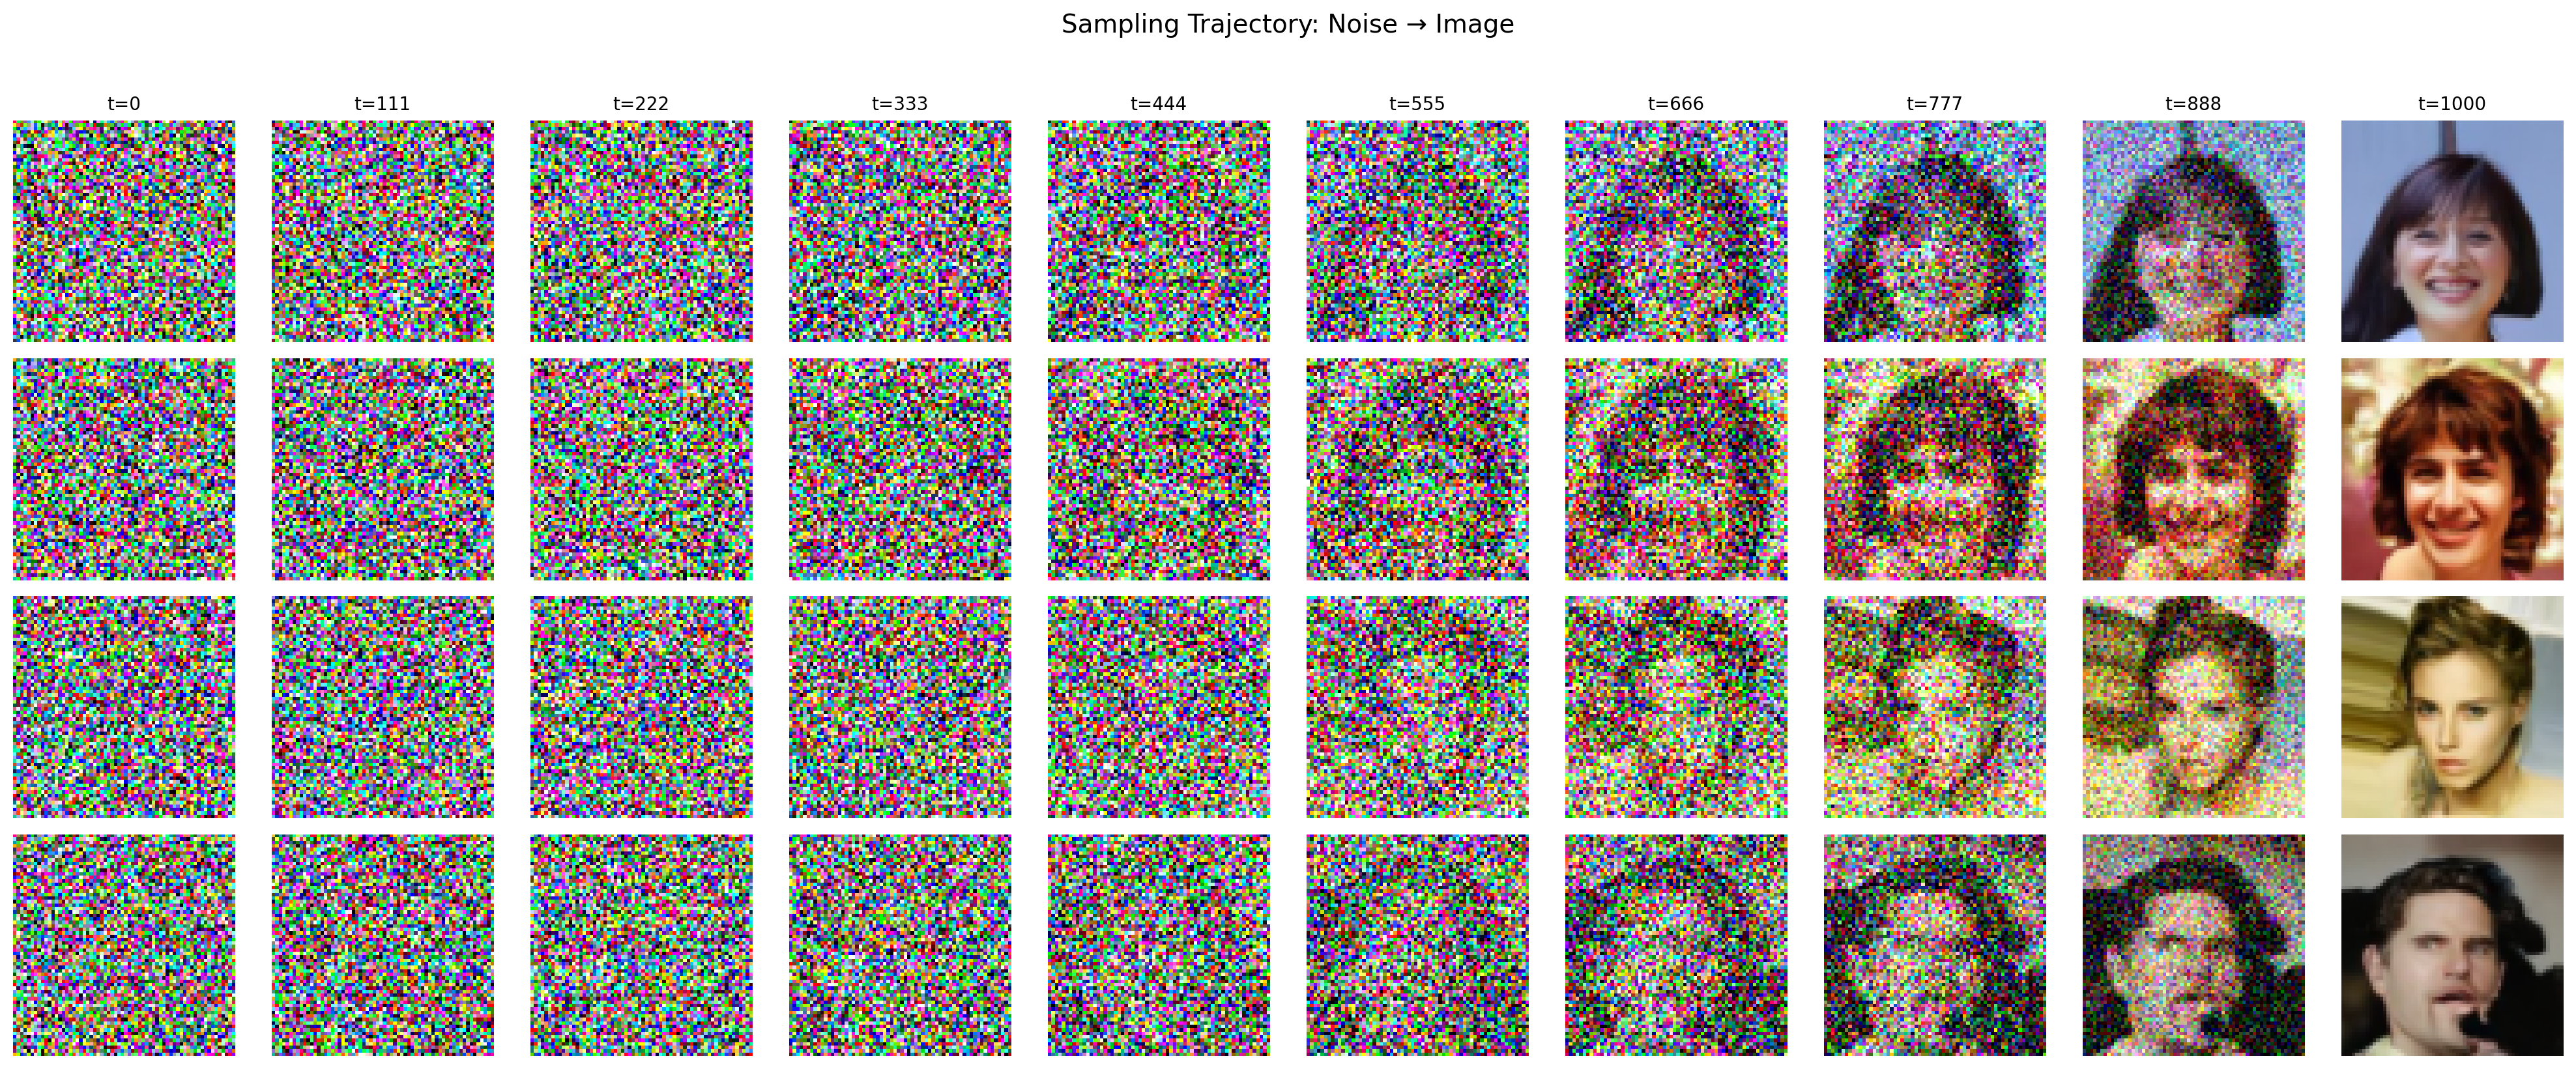

In [ ]:
# Your DDPM sampling code